In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving income.csv to income.csv


{'income.csv': b'age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label\r\n27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0\r\n47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1\r\n59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0\r\n38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1\r\n64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0\r\n53,Male,Masters,14,Married,Private,Prof-specialty,40,>50K,1\r\n23,Male,HS-grad,9,Married,Private,Handlers-cleaners,40,<=50K,0\r\n52,Female,HS-grad,9,Widowed,Private,Craft-repair,40,<=50K,0\r\n31,Male,HS-grad,9,Never-married,Private,Machine-op-inspct,40,<=50K,0\r\n22,Female,HS-grad,9,Married,Private,Adm-clerical,40,<=50K,0\r\n33,Male,HS-grad,9,Married,Private,Other-service,36,<=50K,0\r\n19,Female,HS-grad,9,Never-married,State-gov,Adm-clerical,20,<=50K,0\r\n20,Female,12th,8,Never-married,Private,Adm-clerical,20,<=50K,0\r\n55,Female,5th-6th,

In [4]:
df = pd.read_csv('income.csv')

In [5]:
df

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0
...,...,...,...,...,...,...,...,...,...,...
29995,45,Male,Masters,14,Married,State-gov,Prof-specialty,60,>50K,1
29996,33,Male,HS-grad,9,Married,Private,Machine-op-inspct,40,>50K,1
29997,47,Male,Prof-school,15,Married,Private,Prof-specialty,55,>50K,1
29998,32,Female,Some-college,10,Never-married,Private,Adm-clerical,40,<=50K,0


I Seperate Categorical and Continous features

In [8]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [9]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'education-num', 'hours-per-week']

y_col = ['label']

II **Convert categories to category dtypes**

In [10]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

III Shuffle the Dataset

In [18]:
from sklearn.utils import shuffle

In [17]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [19]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [20]:
cat_szs

[2, 14, 6, 5, 12]

In [21]:
emb_size = [(size, min(50, (size+1)//2)) for size in cat_szs]

In [22]:
emb_size

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

IV Create a stack of numpy array from categorical values

In [23]:
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx, ed, ms, wc, oc], axis=1)

In [24]:
cats

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       ...,
       [ 1, 10,  1,  2,  2],
       [ 0,  6,  3,  2,  0],
       [ 1,  8,  5,  3,  9]], dtype=int8)

**V Convert cats to tensor**

In [25]:
cats = torch.tensor(cats, dtype=torch.int64)

In [31]:
cats

tensor([[ 0, 10,  3,  2,  6],
        [ 0, 12,  1,  4,  7],
        [ 1, 13,  0,  2,  0],
        ...,
        [ 1, 10,  1,  2,  2],
        [ 0,  6,  3,  2,  0],
        [ 1,  8,  5,  3,  9]])

VI Array for Continous values

In [33]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)

VII Convert array to tensor

In [34]:
conts = torch.tensor(conts, dtype=torch.float)

In [35]:
conts

tensor([[23.,  9., 50.],
        [37., 15., 39.],
        [34., 10., 40.],
        ...,
        [62.,  9., 45.],
        [37., 12., 40.],
        [50., 13., 65.]])

VIII Convert label to tensor

In [38]:
y = torch.tensor(df[y_col].values).flatten()

In [39]:
y

tensor([0, 1, 0,  ..., 1, 0, 1])

IX Train and test sets

In [42]:
b = 30000
t = 5000

cat_train = cats[:b-t]
cat_test = cats[b-t:b]

cont_train = conts[:b-t]
cont_test = conts[b-t:b]

y_train = y[:b-t]
y_test = y[b-t:b]

X Define Model

In [61]:
class TabularModel(nn.Module):

  def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
    super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
    layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
    n_emb = sum((nf for ni,nf in emb_szs))
    n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
    for i in layers:
        layerlist.append(nn.Linear(n_in,i)) 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(i))
        layerlist.append(nn.Dropout(p))
        n_in = i
    layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
    self.layers = nn.Sequential(*layerlist)
    
  def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
    embeddings = []
    for i,e in enumerate(self.embeds):
        embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
    x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
    x = self.layers(x)
    return x

In [62]:
torch.manual_seed(33)
model = TabularModel(emb_size, conts.shape[1], 2, [50], 0.4)

XI Define loss and optimizer

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

XII Train the model

In [65]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.89122325
epoch:  26  loss: 0.60635263
epoch:  51  loss: 0.51551920
epoch:  76  loss: 0.46236616
epoch: 101  loss: 0.42993721
epoch: 126  loss: 0.40243548
epoch: 151  loss: 0.37635958
epoch: 176  loss: 0.36376366
epoch: 201  loss: 0.34739462
epoch: 226  loss: 0.33574352
epoch: 251  loss: 0.32853600
epoch: 276  loss: 0.31925416
epoch: 300  loss: 0.31375152

Duration: 91 seconds


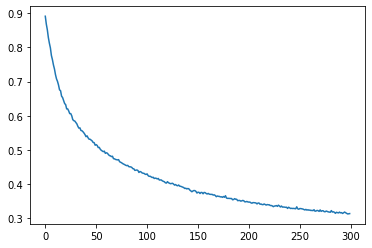

In [67]:
plt.plot(range(epochs),losses)

XIII Evaluate Test set

In [68]:
with torch.no_grad():
  y_val = model(cat_test, cont_test)
  loss = criterion(y_val, y_test)
print(f"loss{loss}")

loss0.33401253819465637


XIV Accuracy

In [70]:
rows = len(y_test)
correct = 0

for i in range(rows):
  if y_val[i].argmax().item() == y_test[i]:
    correct+=1
print(f"Accuracy: {100*correct/rows}")

Accuracy: 84.3


XV Unseen data

In [ ]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

In [73]:
# Save the model though))
torch.save(model.state_dict(), 'income_pytorch.pt')